Pre-Processing of audio signals

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
import noisereduce as nr
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from pyroomacoustics.doa import circ_dist
from scipy.io import wavfile
from scipy.signal import correlate
from scipy.fft import fft, fftfreq, fftshift
from playsound import playsound
from os import listdir
from os.path import isfile, join


/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


In [41]:
audio_file_path = "/Users/nharrison/DOA_Testing/y=3,x=-1/"


file = "/Users/nharrison/DOA_Testing/Room/1.wav"
fs, noise = wavfile.read(file)

for signalindex in range(1,8+1):
    file = audio_file_path + str(signalindex) + ".wav"
    fs, signal = wavfile.read(file)
    denoised = nr.reduce_noise(y=signal,sr=fs,y_noise=noise)
    if signalindex == 1:
        signals = np.zeros((8, len(signal)))
        denoised_signals = np.zeros((8, len(signal)))

    signals[signalindex-1, :] = signal
    denoised_signals[signalindex-1,:] = denoised
    wavfile.write("/Users/nharrison/denoised"+str(signalindex)+".wav", fs, denoised)

#reduced = nr.reduce_noise(y=signalplusnoise,sr=f_sample,y_noise=noise)

#audio_normalized = audio.astype(np.float32) / np.iinfo(np.int32).max
#plt.plot(signalplusnoise)
#plt.plot(reduced)
#wavfile.write("/Users/nharrison/denoised.wav", f_sample, reduced)

/var/folders/4t/rx6h__y129d95fxhwcb9st6w0000gn/T/ipykernel_6450/3212756295.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, noise = wavfile.read(file)
/var/folders/4t/rx6h__y129d95fxhwcb9st6w0000gn/T/ipykernel_6450/3212756295.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(file)


In [42]:
# array geometry
R = pra.linear_2D_array(center=[0,0], M=8, phi=0, d=0.3)

# fourier transform
N = 1024
X = np.array(
    [
        pra.transform.stft.analysis(denoised, N, N // 2).T
        for denoised in denoised_signals
    ]
)

# NormMUSIC algorithm selected, recommended over MUSIC
n_source = 1
doa = pra.doa.normmusic.NormMUSIC(R, fs, N, num_src=n_source, mode='near', azimuth=np.linspace(0, 180, 50)*np.pi/180)
doa.locate_sources(X, freq_bins=np.arange(1, N))
doa_azimuths = doa.azimuth_recon

print(180-doa_azimuths*180/np.pi)

[102.85714286]


41.98250728862973
0.0008746355685131195
108.03830652000083


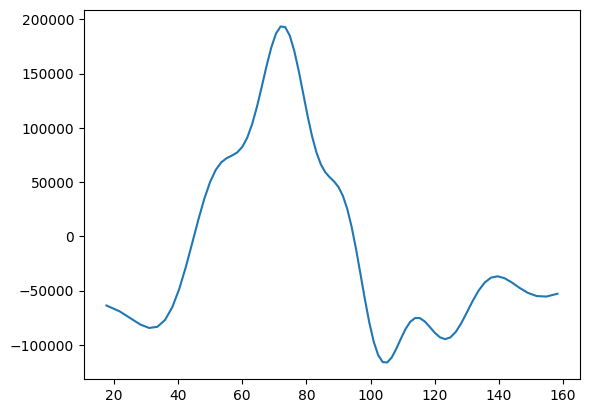

In [43]:
# Try cross-correlation with two mics
nsamples = len(signal)
d=0.3
maxtau = d/343
maxindex = maxtau*fs
print(maxindex)
print(maxtau)
signal1 = denoised_signals[3,:]
signal2 = denoised_signals[4,:]
signal3 = denoised_signals[4,:]
signal4 = denoised_signals[5,:]
signal1 = (signal1) / np.std(signal1)
signal2 = (signal2) / np.std(signal2)
signal3 = (signal3) / np.std(signal3)
signal4 = (signal4) / np.std(signal4)

z = correlate(signal1,signal2)
zvalid = z[nsamples-40:nsamples+40]
taurange = 1/fs*np.arange(-len(signal1)+1,len(signal1))
tauvalid = taurange[nsamples-40:nsamples+40]
thetavalid = np.arccos(343*tauvalid/d)
#plt.plot(taurange[nsamples-40:nsamples+40],z[nsamples-40:nsamples+40])
#delay_index = np.argmax(z[nsamples-40:nsamples+40])
#print(delay_index)
#tau = taurange[nsamples-40:nsamples+40][delay_index]
#print(tau)
#l = 343*tau
#print(l)
#theta = np.arccos(l/d)
#print(180/np.pi*theta)
plt.plot(thetavalid*180/np.pi,zvalid)
theta = thetavalid[np.argmax(zvalid)]
print(180-theta*180/np.pi)


(2, 10240)
(2, 10240)
(1024,)
[[1.00009767 0.00257555]
 [0.00257555 1.00009767]]
89.85243140926163


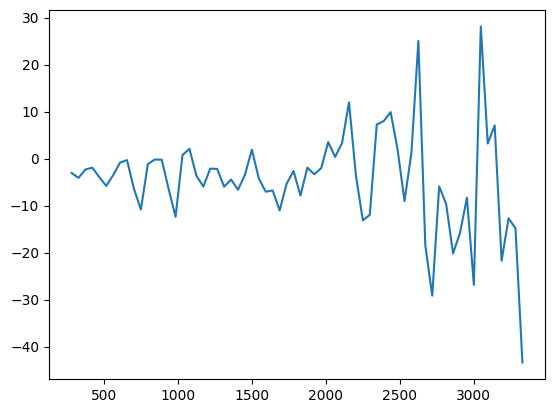

In [44]:
# use delay array for package
N=1024
T = 1/fs
delays = []
start = 200000
flow =300
fhigh =3400

data1 = signal1[start:start+10*N]
data2 = signal2[start:start+10*N]
data1 = np.divide(data1,np.sqrt(np.var(data1)))
data2 = np.divide(data2,np.sqrt(np.var(data2)))
data = np.array([data1,data2])
normdata = data
print(data.shape)
fft1 = fft(data)
print(fft1.shape)
freq = fftfreq(N,d=T)
print(freq.shape)

Nlow = flow*N//fs
Nhigh = fhigh*N//fs

plt.plot(freq[Nlow:Nhigh],fft1.real[0,Nlow:Nhigh])
#plt.plot(fft(data1))
#plt.plot(fft(data2))


# take covariance array of data

covariance = np.cov(normdata)
#for i in range(2):
    #for j in range(2):
        #z = correlate(data[i,:],data[j,:])
        #plt.plot(z)
        #print(np.argmax(z))

print(covariance)
print(180/np.pi*np.arccos(covariance[1,0]))


eigenvalues, eigenvectors = np.linalg.eig(covariance)
#print(eigenvalues)
#print(eigenvectors)


(2, 10240)
(2, 513, 20)
2
20
[72.40223464]


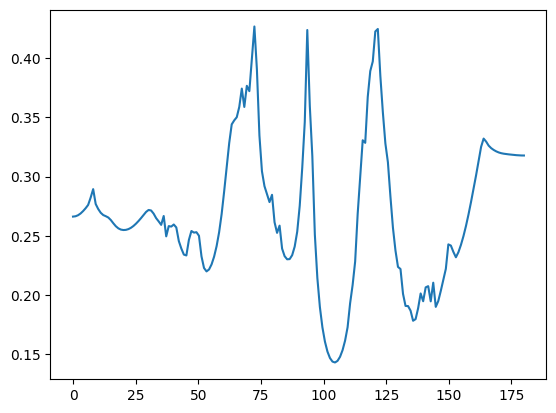

In [45]:
# design parameters of array
array_loc = [0, 0] # x/y location of array center
n_mics = 8 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

fft1 = np.array(fft1)
fft1 = fft1.reshape([fft1.shape[0],fft1.shape[1],1])
print(data.shape)


X = pra.transform.stft.analysis(data.T, N, N//2)
print(X.T.shape)

R = pra.linear_2D_array(center=array_loc, M=2, phi=0, d=sep)
music = pra.doa.normmusic.NormMUSIC(R, fs, N,num_src=1,azimuth = np.linspace(0, 180, 180)*np.pi/180,mode='near')
print(music.M)
print(X.shape[0])
music.locate_sources(X.T,freq_range = [flow,fhigh])
print(music.azimuth_recon*180/np.pi)
plt.plot(music.grid.azimuth*180/np.pi,music.grid.values)


(1024,)


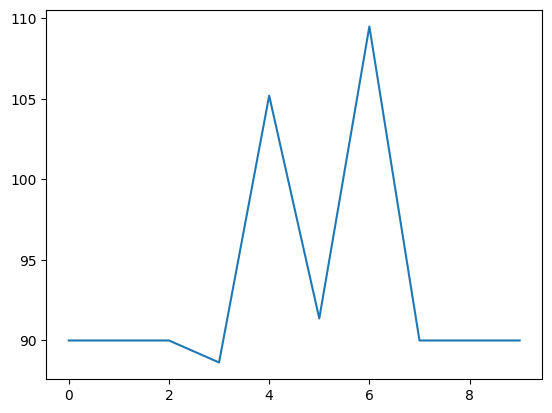

In [46]:
# now try to split into packages
npackages = 10
packagesize = 1024
nstep = nsamples//npackages
signal1packages = np.array(
    [
        signal1[nstep*i:nstep*i+packagesize]
        for i in range(npackages)
    ]
)
signal2packages = np.array(
    [
        signal2[nstep*i:nstep*i+packagesize]
        for i in range(npackages)
    ]
)
signal3packages = np.array(
    [
        signal3[nstep*i:nstep*i+packagesize]
        for i in range(npackages)
    ]
)
signal4packages = np.array(
    [
        signal4[nstep*i:nstep*i+packagesize]
        for i in range(npackages)
    ]
)

print(signal1packages[1,:].shape)

thetas = np.zeros(npackages)
for i in range(npackages):
    z = correlate(signal1packages[i,:],signal2packages[i,:])
    
    zvalid = z[packagesize-40:packagesize+40]
    taurange = 1/fs*np.arange(-packagesize+1,packagesize)
    tauvalid = taurange[packagesize-40:packagesize+40]
    thetavalid = np.arccos(343*tauvalid/d)
    theta = thetavalid[np.argmax(zvalid)]
    thetas[i] = theta

#print(thetas*180/np.pi)
#plt.plot(180-thetas*180/np.pi)
thetas = np.zeros(npackages)
for i in range(npackages):
    z1 = correlate(signal1packages[i,:],signal2packages[i,:])
    z2 = correlate(signal2packages[i,:],signal3packages[i,:])
    z3 = correlate(signal3packages[i,:],signal4packages[i,:])
    z = z1+z2+z3
    
    zvalid = z[packagesize-40:packagesize+40]
    taurange = 1/fs*np.arange(-packagesize+1,packagesize)
    tauvalid = taurange[packagesize-40:packagesize+40]
    thetavalid = np.arccos(343*tauvalid/d)
    theta = thetavalid[np.argmax(zvalid)]
    thetas[i] = theta

#print(thetas*180/np.pi)
plt.plot(180-thetas*180/np.pi)